# Group 1:
- Duarte Velho (pg53841)
- Joana Lopes (pg53498)
- João Ferreira (pg52182)
- Ricardo Oliveira (pg53501)

In [2]:
import cobra
from cobra.flux_analysis import flux_variability_analysis
import mewpy
from mewpy.visualization.envelope import plot_flux_envelope
from mewpy.simulation import get_simulator
from mewpy.omics import eFlux
from mewpy.optimization.evaluation import BPCY
from mewpy.optimization.evaluation import WYIELD
from mewpy.omics import ExpressionSet
from mewpy.optimization import EA
from mewpy.problems import GOUProblem
from mewpy.problems import GKOProblem
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
model=cobra.io.read_sbml_model("iRC1080_lv3.xml") #loading the model

In [3]:
model.medium # default medium composition

{'EX_no3_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_h_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_photonVis_e': 2000.0,
 'EX_o2_e': 10.0,
 'EX_co2_e': 11.16,
 'EX_ac_e': 10.0}

In [14]:
# some information about the model
print("Number of metabolites:",len(model.metabolites))
print("Number of reactions:",len(model.reactions))
print("Number of genes:",len(model.genes))

#search of the exhcange reactions of interst
queries=["EX_ph","EX_co","EX_o2","EX_ac","star"]
ex_ids=[]
for query in queries:
    ex_ids+=[model.reactions.query(query)[0].id]

print("Exchange ids:",ex_ids)

Number of metabolites: 1706
Number of reactions: 2191
Number of genes: 1086
Exchange ids: ['EX_photonVis_e', 'EX_co2_e', 'EX_o2_e', 'EX_ac_e', 'SK_starch300_h']


In [5]:
# bounds analysis of the exhanges reactions of interest for this work on the default model
for exchange in model.exchanges:
    if exchange.id in ex_ids:
        print(f"{exchange.name}:")
        print(f"-lower bound: {exchange.lower_bound}")
        print(f"-upper bound: {exchange.upper_bound}",end="\n\n")

Photon emission:
-lower bound: -2000.0
-upper bound: 1000.0

O2 exchange:
-lower bound: -10.0
-upper bound: 1000.0

CO2 exchange:
-lower bound: -11.16
-upper bound: 1000.0

Acetate exchange:
-lower bound: -10.0
-upper bound: 1000.0



# Ex 1



## a) What is the maximum growth rate achieved by the organism in each condition?  Which metabolites are consumed and produced?

In [17]:
growth_env=["Aerobic autotrophic","Microaerobic autotrophic","Aerobic heterotrophic","Microaerobic heterotrophic",
    "Aerobic mixotrophic","Microaerobic mixotrophic"] #contidions in study

model_1=model.copy()

In [15]:
#functions needed to exercise 1

def restricoes(cond_growth:str,model_1):
    """
    This function recieves the enviromental condition and makes the respective medium modifications
    """
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']
    condition={
        "Aerobic autotrophic"        : [-2000,-11.16,-10,0,0],
        "Microaerobic autotrophic"   : [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic"      : [0,-11.16,-10,-10,-1.72e-4],
        "Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic"        : [-2000,-11.16,-10,-10,-1.72e-4],
        "Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]
    }

    for reaction_id,uptake in zip(exchage_interest,condition[cond_growth]):
        if model_1.reactions.get_by_id(reaction_id).lower_bound!=uptake:
            model_1.reactions.get_by_id(reaction_id).lower_bound=uptake

def rmv_prism(cond_growth:str,model_1):
    '''
    This function removes the PRISM reactions when light is absence in the medium
    '''
    prism=model_1.reactions.query("PRISM")
    lower_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    upper_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    
    if "heterotrophic" in cond_growth:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_1.reactions.get_by_id(reaction_id).lower_bound=0
            model_1.reactions.get_by_id(reaction_id).upper_bound=0

    else:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_1.reactions.get_by_id(reaction_id).upper_bound= upper_default[I]
            model_1.reactions.get_by_id(reaction_id).lower_bound= lower_default[I]

def opt_objetctive(cond_growth:str,model_1):
    "This funcion modifies the optimization objetive depending on the enviromental conditions wanted"

    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}
    
    objective_reaction=model_1.reactions.get_by_id(env_cond[cond_growth])
    model_1.objective=objective_reaction
    return model_1.objective

def optimization(cond_growth:str,model_1):
    '''
    This function makes the model optimizations depending on the enviromental condition given
    '''
    restricoes(cond_growth,model_1)
    rmv_prism(cond_growth,model_1)
    opt_objetctive(cond_growth,model_1)
    solution=model_1.optimize()
    return solution

def maximum_growth_rate(conds_growth:list[str],model_1)->dict[str,float]:
    '''
    This function recieves all the enviromental conditions in study and gives back the growth rate for each condition 
    when the objetive reaction it's the biomass production
    '''
    growth_rate={}
    for cond in conds_growth:
        solution=optimization(cond,model_1)
        growth_rate[cond]=solution.objective_value
    return growth_rate

def consumed_metabolites(conds_growth:list[str],model_1)->dict[str,dict[str,float]]:
    '''
    This function recieves all the enviromental conditions in study and gives back the metabolites used by the organism
    for each condition
    '''
    metabolites={}
    for cond in conds_growth:
        solution=optimization(cond,model_1)
        metabolites_list=[]
        for metabolite,flux in zip(model_1.summary().uptake_flux.metabolite,model_1.summary().uptake_flux.flux):
            if flux!=0:
                metabolites_list=[metabolite]+ metabolites_list
        metabolites[cond]=metabolites_list
    
    return metabolites

def produced_metabolites(conds_growth:list[str],model_1)->dict[str,dict[str,float]]:
    '''
    This function recieves all the enviromental conditions in study and gives back the metabolites produced by the organism
    for each condition
    '''
    prod_metabolites={}
    for cond in conds_growth:
        solution=optimization(cond,model_1)
        metabolites_list=[]
        for metabolite,flux in zip(model_1.summary().secretion_flux.metabolite,model_1.summary().secretion_flux.flux):
            if flux!=0:
                metabolites_list=[metabolite]+ metabolites_list
        prod_metabolites[cond]=metabolites_list
    
    return prod_metabolites

### Maximum growth rate for each condition

In [18]:
growth_a=maximum_growth_rate(growth_env,model_1) #maximum growth rate for each enviromental condition

print("Maximum growth rate:",end="\n\n")
for cond,growth in growth_a.items():
    print(f"- {cond}:",round(growth,4),"h-1")

Maximum growth rate:

- Aerobic autotrophic: 0.158 h-1
- Microaerobic autotrophic: 0.0108 h-1
- Aerobic heterotrophic: 0.323 h-1
- Microaerobic heterotrophic: 0.0069 h-1
- Aerobic mixotrophic: 0.4158 h-1
- Microaerobic mixotrophic: 0.0112 h-1


The maximum growth rates achieved for the organism in each condition are:

- Aerobic autotrophic: 0.158 h-1
- Microaerobic autotrophic: 0.0108 h-1
- Aerobic heterotrophic: 0.323 h-1
- Microaerobic heterotrophic: 0.0069 h-1
- Aerobic mixotrophic: 0.4158 h-1
- Microaerobic mixotrophic: 0.0112 h-1

### Consumed metabolites for each condition


In [19]:
uptake_metabolites=consumed_metabolites(growth_env,model_1) # general metabolites consumed for each condition

print("Consumed metabolites for each condition:",end="\n\n")
for cond,metabolites in uptake_metabolites.items():
    print(f"{cond}:")
    for metabolite in metabolites:
        print(f"-{metabolite}")
    print("")

Consumed metabolites for each condition:

Aerobic autotrophic:
-so4_e
-pi_e
-photonVis_e
-o2_e
-no3_e
-nh4_e
-na1_e
-mg2_e
-h2o_e
-co2_e

Microaerobic autotrophic:
-so4_e
-pi_e
-photonVis_e
-o2_e
-no3_e
-nh4_e
-na1_e
-mg2_e
-h2o_e
-co2_e

Aerobic heterotrophic:
-starch300_h
-so4_e
-pi_e
-o2_e
-no3_e
-nh4_e
-na1_e
-mg2_e
-ac_e

Microaerobic heterotrophic:
-starch300_h
-so4_e
-pi_e
-o2_e
-no3_e
-nh4_e
-na1_e
-mg2_e
-ac_e

Aerobic mixotrophic:
-starch300_h
-so4_e
-pi_e
-photonVis_e
-o2_e
-no3_e
-nh4_e
-na1_e
-mg2_e
-ac_e

Microaerobic mixotrophic:
-starch300_h
-so4_e
-pi_e
-photonVis_e
-o2_e
-no3_e
-nh4_e
-na1_e
-mg2_e
-h2o_e
-co2_e
-ac_e



The metabolites consumed in each condition are:
- Aerobic autotrophic:
    - CO2 (carbon dioxide)
    - Mg (magnesium)
    - Na (sodium)
    - NH4 (ammonium)
    - NO3 (Nitrate)
    - O2
    - Photon (380 to 750 nm, visible spectrum)
    - HPO4 (Phosphate)
    - SO4 (Sulfate)

- Microaerobic autotrophic:
    - CO2 (carbon dioxide)
    - Mg (magnesium)
    - Na (sodium)
    - NH4 (ammonium)
    - NO3 (Nitrate)
    - O2
    - Photon (380 to 750 nm, visible spectrum)
    - HPO4 (Phosphate)
    - SO4 (Sulfate)

- Aerobic heterotrophic:
    - C2H3O2 (acetate)
    - Mg (magnesium)
    - Na (sodium)
    - NH4 (ammonium)
    - NO3 (Nitrate)
    - O2
    - HPO4 (Phosphate)
    - SO4 (Sulfate)
    - Starch

- Microaerobic heterotrophic:
    - C2H3O2 (acetate)
    - Mg (magnesium)
    - Na (sodium)
    - NH4 (ammonium)
    - NO3 (Nitrate)
    - O2
    - HPO4 (Phosphate)
    - SO4 (Sulfate)
    - Starch

- Aerobic mixotrophic:
    - C2H3O2 (acetate)
    - Mg (magnesium)
    - Na (sodium)
    - NH4 (ammonium)
    - NO3 (Nitrate)
    - O2
    - Photon (380 to 750 nm, visible spectrum)
    - HPO4 (Phosphate)
    - SO4 (Sulfate)
    - Starch

- Microaerobic mixotrophic:
    - C2H3O2 (acetate)
    - CO2 (carbon dioxide)
    - Mg (magnesium)
    - Na (sodium)
    - NH4 (ammonium)
    - NO3 (Nitrate)
    - O2
    - Photon (380 to 750 nm, visible spectrum)
    - HPO4 (Phosphate)
    - SO4 (Sulfate)
    - Starch

### Produced metabolites for each condition

In [45]:
secreted_metabolites=produced_metabolites(growth_env,model_1) # general metabolites secreted for each condition

print("Produced metabolites for each condition:",end="\n\n")
for cond,metabolites in secreted_metabolites.items():
    print(f"{cond}:")
    for metabolite in metabolites:
        print(f"-{metabolite}")
    print("")

Produced metabolites for each condition:

Aerobic autotrophic:
-h_e
-photon680_u
-photon673_u
-photon646_h
-photon490_s
-photon450_h
-photon438_u
-photon437_u
-photon298_c
-o2D_u
-no_h
-na1_h
-na1_c

Microaerobic autotrophic:
-no2_e
-h_e
-photon680_u
-photon673_u
-photon646_h
-photon490_s
-photon450_h
-photon438_u
-photon437_u
-photon298_c
-o2D_u
-no_h
-na1_x

Aerobic heterotrophic:
-no2_e
-h_e
-h2o_e
-co2_e
-na1_x

Microaerobic heterotrophic:
-no2_e
-h_e
-h2o_e
-etoh_e
-co2_e
-na1_x

Aerobic mixotrophic:
-no2_e
-h_e
-h2o_e
-co2_e
-photon680_u
-photon673_u
-photon646_h
-photon490_s
-photon450_h
-photon438_u
-photon437_u
-photon298_c
-o2D_u
-na1_x

Microaerobic mixotrophic:
-succ_e
-no2_e
-etoh_e
-photon680_u
-photon673_u
-photon646_h
-photon490_s
-photon450_h
-photon438_u
-photon437_u
-photon298_c
-o2D_u
-na1_x



The produced metabolites for each condition are:

- Aerobic autotrophic:
    - H
    - Na (this compound isn't produced, it only appears because, the amount consumed isn't all used, so the rest is secreted to maintain the stationary state rule)
    - NO (this compound isn't produced, it only appears because, all of it isn't consumed, so the rest is secreted to maintain the stationary state rule)
    - O2 (Dummy metabolite to resolve Type IV path. Used to represent the oxygen production during photosynthesis)
    - 'photon298_c' (represent the wave length, 298 nm, that isn't during photosynthesis)
    - 'photon437_u' (represent the wave length, 437 nm, that isn't during photosynthesis)
    - 'photon438_u' (represent the wave length, 438 nm, that isn't during photosynthesis)
    - 'photon450_h' (represent the wave length, 450 nm, that isn't during photosynthesis)
    - 'photon490_s' (represent the wave length, 490 nm, that isn't during photosynthesis)
    - 'photon646_h' (represent the wave length, 646 nm, that isn't during photosynthesis)
    - 'photon673_u' (represent the wave length, 673 nm, that isn't during photosynthesis)
    - 'photon680_u' (represent the wave length, 680 nm, that isn't during photosynthesis)

- Microaerobic autotrophic:
    - H
    - Na (this compound isn't produced, it only appears because, the amount consumed isn't all used, so the rest is secreted to maintain the stationary state rule)
    - NO2
    - NO (this compound isn't produced, it only appears because, all of it isn't consumed, so the rest is secreted to maintain the stationary state rule)
    -  O2 (Dummy metabolite to resolve Type IV path. Used to represent the oxygen production during photosynthesis)
    - 'photon298_c' (represent the wave length, 298 nm, that isn't during photosynthesis)
    - 'photon437_u' (represent the wave length, 437 nm, that isn't during photosynthesis)
    - 'photon438_u' (represent the wave length, 438 nm, that isn't during photosynthesis)
    - 'photon450_h' (represent the wave length, 450 nm, that isn't during photosynthesis)
    - 'photon490_s' (represent the wave length, 490 nm, that isn't during photosynthesis)
    - 'photon646_h' (represent the wave length, 646 nm, that isn't during photosynthesis)
    - 'photon673_u' (represent the wave length, 673 nm, that isn't during photosynthesis)
    - 'photon680_u' (represent the wave length, 680 nm, that isn't during photosynthesis)

- Aerobic heterotrophic:
    - CO2
    - H
    - Na (this compound isn't produced, it only appears because, the amount consumed isn't all used, so the rest is secreted to maintain the stationary state rule)
    - NO2


- Microaerobic heterotrophic:
    - CO2
    - C2H6O (Ethanol)
    - H
    - Na (this compound isn't produced, it only appears because, the amount consumed isn't all used, so the rest is secreted to maintain the stationary state rule)
    - NO2

- Aerobic mixotrophic
    - CO2
    - H
    - Na (this compound isn't produced, it only appears because, the amount consumed isn't all used, so the rest is secreted to maintain the stationary state rule)
    - NO2
    - O2 (Dummy metabolite to resolve Type IV path. Used to represent the oxygen production during photosynthesis)
    - 'photon298_c' (represent the wave length, 298 nm, that isn't during photosynthesis)
    - 'photon437_u' (represent the wave length, 437 nm, that isn't during photosynthesis)
    - 'photon438_u' (represent the wave length, 438 nm, that isn't during photosynthesis)
    - 'photon450_h' (represent the wave length, 450 nm, that isn't during photosynthesis)
    - 'photon490_s' (represent the wave length, 490 nm, that isn't during photosynthesis)
    - 'photon646_h' (represent the wave length, 646 nm, that isn't during photosynthesis)
    - 'photon673_u' (represent the wave length, 673 nm, that isn't during photosynthesis)
    - 'photon680_u' (represent the wave length, 680 nm, that isn't during photosynthesis)

- Microaerobic mixotrophic
    - C2H6O (Ethanol)
    - Na (this compound isn't produced, it only appears because, the amount consumed isn't all used, so the rest is secreted to maintain the stationary state rule)
    - NO2
    - O2 (Dummy metabolite to resolve Type IV path. Used to represent the oxygen production during photosynthesis)
    - 'photon298_c' (represent the wave length, 298 nm, that isn't during photosynthesis)
    - 'photon437_u' (represent the wave length, 437 nm, that isn't during photosynthesis)
    - 'photon438_u' (represent the wave length, 438 nm, that isn't during photosynthesis)
    - 'photon450_h' (represent the wave length, 450 nm, that isn't during photosynthesis)
    - 'photon490_s' (represent the wave length, 490 nm, that isn't during photosynthesis)
    - 'photon646_h' (represent the wave length, 646 nm, that isn't during photosynthesis)
    - 'photon673_u' (represent the wave length, 673 nm, that isn't during photosynthesis)
    - 'photon680_u' (represent the wave length, 680 nm, that isn't during photosynthesis)
    - C4H4O4(Succinate)

## b) What is the wild-type production of the compound of interest?

In [20]:
#functions needed for exercise 1b)
def consumed_metabolites_flux(conds_growth:list[str],model_1)->dict[str,dict[str,float]]:
    '''
    This function recieves all the enviromental conditions in study and gives back the metabolites used by the organism
    for each condition
    '''
    metabolites={}
    for cond in conds_growth:
        solution=optimization(cond,model_1)
        metabolites[cond]={}
        for metabolite,flux in zip(model_1.summary().uptake_flux.metabolite,model_1.summary().uptake_flux.flux):
            if flux!=0:
                metabolites[cond][metabolite]=flux
    
    return metabolites

def produced_metabolites_flux(conds_growth:list[str],model_1)->dict[str,dict[str,float]]:
    '''
    This function recieves all the enviromental conditions in study and gives back the metabolites produced by the organism
    for each condition
    '''
    prod_metabolites={}
    for cond in conds_growth:
        solution=optimization(cond,model_1)
        prod_metabolites[cond]={}
        for metabolite,flux in zip(model_1.summary().secretion_flux.metabolite,model_1.summary().secretion_flux.flux):
            if flux!=0:
                prod_metabolites[cond][metabolite]=flux
    
    return prod_metabolites

def compound_int(conds_growth: list[str],produced_metabolites:dict[str,dict[str,float]],compound:str)->dict[str,dict[str,float]]:
    """
    This function gives the flux for the production of a given compound of interest for each enviromental condition
    """
    production={}
    for cond in conds_growth:
        metabolites=produced_metabolites[cond]
        if compound not in metabolites:
            pass
        else:
            production[cond]={}
            for metabolite,flux in metabolites.items():
                if metabolite==compound:
                    production[cond][metabolite]=flux
                
    return production

def carbon_source(compound_int,consumed_metabolites:dict[str,dict[str,float]])-> dict[str,dict[str,float]]:
    """
    This function recieves que list of the compound of interest and the consumed metabolites and gives back the carbon
    sources for the conditions that produce the compound
    """
    carbons=['co2_e','ac_e','starch300_h']
    res={}
    for cond in compound_int:
        metabolites=consumed_metabolites[cond]
        res[cond]={}
        for metabolite,flux in metabolites.items():
            if metabolite in carbons:
                res[cond][metabolite]=flux
    
    return res

def carbon_number(id:str)->int:
    """
    This function recives the id of a given metabolite and give back the number of carbons of that metabolite
    """
    if id=="starch300_h":
        number_of_carbons=6*300
    else:
        metabolite = model.metabolites.get_by_id(id)
        number_of_carbons = metabolite.elements.get('C',0)
    return number_of_carbons

def BCPY_group1(product:dict[str,dict[str,float]],growth_a:dict[str,float],substrate:dict[str,dict[str,float]])->float:
    """
    This function calculates the BCPY value for the porduction of certain product
    """
    res={}
    for env_cond in product:
        product_flux=product[env_cond]["succ_e"]*carbon_number('succ_e')
        growth_rate=growth_a[env_cond]
        carbon_flux=0
        for carbon,flux in substrate[env_cond].items():
            carbon_flux+=flux*carbon_number(carbon)
        res[env_cond]=-(product_flux*growth_rate)/(carbon_flux)
    return res

In [21]:
uptake_metabolites_flux=consumed_metabolites_flux(growth_env,model_1) # general metabolites consumed for each condition
secreted_metabolites_flux=produced_metabolites_flux(growth_env,model_1) # general metabolites secreted for each condition
succ_e=compound_int(growth_env,secreted_metabolites_flux,"succ_e") # conditions where the compound of interest is produced and the respective flux
substrates=carbon_source(succ_e,uptake_metabolites_flux) # carbon sources of the conditions that produce the compound of interest
production=BCPY_group1(succ_e,growth_a,substrates) # production rate of succinate

print("Compound of interest: succiante")
for con,value in production.items():
    print(f"-{con}:", "{:0.2e} mmol/gDW/h".format(value))

Compound of interest: succiante
-Microaerobic mixotrophic: 2.09e-03 mmol/gDW/h


The wild-type organism only showed the production of the compound of interest (succinate) in the Microaerobic mixotrophic condition with a value of $2.09\times10^{-3}$ mmol/gDW/h

## c)Access the robustness of the presented solutions using the Flux Variability. Analysis approach

In [10]:
#function for exercise 1c)
def fva(conds_growth:list[str],model_1):
    """
    This function evaluates the robustness of the presented solutions by the fba method
    """
    res={}
    for cond in conds_growth:
        fba=optimization(cond,model_1)
        fva_cond=model_1.summary(fva=0.95)
        for metabolite,minimum,maximum in zip(fva_cond.secretion_flux.metabolite,fva_cond.secretion_flux.minimum,fva_cond.secretion_flux.maximum):
            if metabolite=="succ_e":
                min_max=[minimum,maximum]
                res[cond]=min_max

    return res           

In [62]:
results_fva=fva(growth_env,model_1) # fva results for the production of succinate

for cond,fluxes in results_fva.items(): # printing the results organized
    print(f"{cond}: flux min={fluxes[0]}, flux max={fluxes[1]}")

Aerobic autotrophic: flux min=-0.16377000000008304, flux max=0.0
Microaerobic autotrophic: flux min=-2.3298361034185238, flux max=0.0
Aerobic heterotrophic: flux min=-0.25436199999997583, flux max=0.0
Microaerobic heterotrophic: flux min=-4.984376443894994, flux max=0.0
Aerobic mixotrophic: flux min=-0.4199620000000393, flux max=0.0
Microaerobic mixotrophic: flux min=-7.766147217712191, flux max=0.0


<div align='justify'>

Note: We are using the model.summary() method, so the negative flux means that the compound is being secreted, while the positive means the compound is being consumed by the organism.

After performing the fva optmization we can conclude that the solutions presented aren't robust.
For the first 5 environmental conditions, the fba solutions showed that the organism doesn't produce succinate, although the fva optimizations resulted on an interval between a negative number and zero which means that we can't assure that the compound of interest isn't being produced in those conditions, only an interval between zero [0,0] could make us conclude that the compound isn't being produced.
The last condition, had production in the fba optimization, but the fva approach results in an interval between a negative number and zero which means that we can't conclude that the organism is producing the compound of interest and if it produces the compound the production rate will vary between the minimum and the maximum flux not having a fixed value.
</div>


## d) What are the maximum compound production capabilities, guaranteeing a minimum growth rate of 20% of the wild type?

In [22]:
model_1_d=model.copy()

In [23]:
#functions to solve exercise 1d)

def restricoes_biomass(cond_growth:str,model_1_d,growth_a:dict[str,float]):
    '''
    This function modify the lower bound of the biomass reaction to a minimum of 20% of the maximum growth when the
    objective reaction is the biomass production
    '''
    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}

    
    for cond in env_cond:
        if cond==cond_growth:
            min_growth=growth_a[cond_growth]*0.2
            model_1_d.reactions.get_by_id(env_cond[cond_growth]).lower_bound=min_growth
        elif env_cond[cond]==env_cond[cond_growth]:
            pass
        else:
            model_1_d.reactions.get_by_id(env_cond[cond]).lower_bound=0

def restricoes_1_d (cond_growth:str,model_1_d):
    """
    This function recieves the enviromental condition and makes the respective medium modifications
    """
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']
    condition={
        "Aerobic autotrophic"        : [-2000,-11.16,-10,0,0],
        "Microaerobic autotrophic"   : [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic"      : [0,-11.16,-10,-10,-1.72e-4],
        "Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic"        : [-2000,-11.16,-10,-10,-1.72e-4],
        "Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]
    }

    for reaction_id,uptake in zip(exchage_interest,condition[cond_growth]):
        model_1_d.reactions.get_by_id(reaction_id).lower_bound=uptake

def rmv_prism_1_d(cond_growth:str,model_1_d):
    '''
    This function removes the PRISM reactions when light is absence in the medium
    '''
    prism=model_1_d.reactions.query("PRISM")
    lower_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    upper_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    
    if "heterotrophic" in cond_growth:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_1_d.reactions.get_by_id(reaction_id).lower_bound=0
            model_1_d.reactions.get_by_id(reaction_id).upper_bound=0

    else:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_1_d.reactions.get_by_id(reaction_id).upper_bound= upper_default[I]
            model_1_d.reactions.get_by_id(reaction_id).lower_bound= lower_default[I]

def opt_objetctive_succ(model_1_d):
    '''
    This function alters the optimization objective to the reaction of the desired compound
    '''
    objective_reaction=model_1_d.reactions.get_by_id("EX_succ_e")
    model_1_d.objective=objective_reaction
    return model_1_d.objective

def optimization_succ(cond_growth:str,model_1_d,growth_a:dict[str,float]):
    '''
    This function makes the fba optimization using the reaction of "Ex_succ_e" as the optimization objective. The 
    minimun growth rate is set to 20%
    '''
    restricoes_1_d (cond_growth,model_1_d)
    restricoes_biomass(cond_growth,model_1_d,growth_a)
    rmv_prism_1_d(cond_growth,model_1_d)
    opt_objetctive_succ(model_1_d)
    solution=model_1_d.optimize()
    return solution

def produced_metabolites_succ(conds_growth:list[str],model_1_d,growth_a:dict[str,float]):
    '''
    This function  gives back all the metabolites produced for each enviromental condition
    '''

    prod_metabolites={}
    for cond in conds_growth:
        solution=optimization_succ(cond,model_1_d,growth_a)
        prod_metabolites[cond]={}
        for metabolite,flux in zip(model_1_d.summary().secretion_flux.metabolite,model_1_d.summary().secretion_flux.flux):
            if metabolite=="succ_e":
                prod_metabolites[cond][metabolite]=flux
    
    return prod_metabolites

def consumed_metabolites_succ(conds_growth,model_1_d,growth_a):
    '''
    This function gives back all the metabolites used in each enviromental condtion
    '''
    metabolites={}
    for cond in conds_growth:
        solution=optimization_succ(cond,model_1_d,growth_a)
        metabolites[cond]={}
        for metabolite,flux in zip(model_1_d.summary().uptake_flux.metabolite,model_1_d.summary().uptake_flux.flux):
            if flux!=0:
                metabolites[cond][metabolite]=flux
    
    return metabolites

def maximum_growth_rate_succ(conds_growth:list[str],model_1_d,growth_a):
    '''
    This function gives back all the maximum growth rate achieved for each environmental condition
    '''
    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}
    
    growth_rate={}
    for cond in conds_growth:
        solution=optimization_succ(cond,model_1_d,growth_a)
        growth_rate[cond]=solution.get_primal_by_id(env_cond[cond])
    return growth_rate

def fva_1_d(conds_growth:list[str],model_1_d,growth_a):
    """
    This function evaluates the robustness of the presented solutions by the fba method
    """
    res={}
    for cond in conds_growth:
        fba=optimization_succ(cond,model_1_d,growth_a)
        fva_cond=model_1_d.summary(fva=0.95)
        for metabolite,minimum,maximum in zip(fva_cond.secretion_flux.metabolite,fva_cond.secretion_flux.minimum,fva_cond.secretion_flux.maximum):
            if metabolite=="succ_e":
                min_max=[minimum,maximum]
                res[cond]=min_max

    return res

In [24]:
maximum_growth_succ=maximum_growth_rate_succ(growth_env,model_1_d,growth_a) #maximum growth rate for each condition guarenting a minimum growth of 20%

#printing the results
print("Maximum growth rate guaranteeing a minimum growth rate of 20% of the wild type",end="\n\n")
for cond,growth in maximum_growth_succ.items():
    print(f"-{cond}:",round(growth,4),"h-1")

Maximum growth rate guaranteeing a minimum growth rate of 20% of the wild type

-Aerobic autotrophic: 0.0316 h-1
-Microaerobic autotrophic: 0.0022 h-1
-Aerobic heterotrophic: 0.0646 h-1
-Microaerobic heterotrophic: 0.0014 h-1
-Aerobic mixotrophic: 0.0832 h-1
-Microaerobic mixotrophic: 0.0022 h-1


Maximum growth rate achieved for each environmental condition guaranteeing a **minimum growth rate of 20% of the wild type**:

- Aerobic autotrophic: 0.0316 h-1
- Microaerobic autotrophic: 0.0022 h-1
- Aerobic heterotrophic: 0.0646 h-1
- Microaerobic heterotrophic: 0.0014 h-1
- Aerobic mixotrophic: 0.0832 h-1
- Microaerobic mixotrophic: 0.0022 h-1

Maximum growth rate achieved for each environmental condition for the **wild type**:
- Aerobic autotrophic: 0.158 h-1
- Microaerobic autotrophic: 0.0108 h-1
- Aerobic heterotrophic: 0.323 h-1
- Microaerobic heterotrophic: 0.0069 h-1
- Aerobic mixotrophic: 0.4158 h-1
- Microaerobic mixotrophic: 0.0112 h-1


<div align='justify'>
Comparing the results is possible to conclude that the wild type achieves a higher growth rate, these results are according to what we expected
</div>

In [25]:
maximization_succ_e=produced_metabolites_succ(growth_env,model_1_d,growth_a) # all metabolites produced for each condition
maximization_succ_e_uptake=consumed_metabolites_succ(growth_env,model_1_d,growth_a) # all metabolites consumed for each condition
succ_flux=compound_int(growth_env,maximization_succ_e,"succ_e") # succinate fluxes for each condition
carbon_succ=carbon_source(succ_flux,maximization_succ_e_uptake) # carbon sources for each condition
production_succ=BCPY_group1(succ_flux,maximum_growth_succ,carbon_succ) #production rate of succinate

#priting the results
print("Compound of interest: succiante")
for cond,value in production_succ.items():
    print(f"- {cond}:", "{:0.2e} mmol/gDW/h".format(value))

Compound of interest: succiante
- Aerobic autotrophic: 2.75e-02 mmol/gDW/h
- Microaerobic autotrophic: 2.15e-03 mmol/gDW/h
- Aerobic heterotrophic: 5.18e-02 mmol/gDW/h
- Microaerobic heterotrophic: 1.37e-03 mmol/gDW/h
- Aerobic mixotrophic: 7.44e-02 mmol/gDW/h
- Microaerobic mixotrophic: 2.24e-03 mmol/gDW/h


<div align='justify'>
When we use the reaction of "EX_succ_e" as optimization objective all the conditions show the production of succinate, while the wild type only shoewd the producion of succinate for microaerobic mixotrophic . 

The values of the production of succinate for each condition are:

- Aerobic autotrophic: $2.75\times10^{-2}$ mmol/gDW/h 
- Microaerobic autotrophic: $2.15\times10^{-3}$ mmol/gDW/h
- Aerobic heterotrophic: $5.18\times10^{-2}$ mmol/gDW/h
- Microaerobic heterotrophic: $1.37\times10^{-3}$ mmol/gDW/h
- Aerobic mixotrophic: $7.44\times10^{-2}$ mmol/gDW/h
- Microaerobic mixotrophic: $2.24\times10^{-3}$ mmol/gDW/h

When comparing the result for Microaerobic mixotrophic with the wild type for the same environmental condition ($2.09\times10^{-3}$ mmol/gDW/h) we observe an increase of 7.17% in the succinate production

</div>

In [17]:
# accessing the robustness of the results
results_fva_1_d=fva_1_d(growth_env,model_1_d,growth_a)
for cond,fluxes in results_fva_1_d.items():
    print(f"{cond}: flux min={fluxes[0]}, flux max={fluxes[1]}")

Aerobic autotrophic: flux min=-2.055137398041077, flux max=-1.95238052813893
Microaerobic autotrophic: flux min=-2.43456235995821, flux max=-2.31283424041488
Aerobic heterotrophic: flux min=-4.069792000000039, flux max=-3.86630240000001
Microaerobic heterotrophic: flux min=-5.065580139758246, flux max=-4.81230111886709
Aerobic mixotrophic: flux min=-6.719392000000095, flux max=-6.38342239999996
Microaerobic mixotrophic: flux min=-7.846083663260582, flux max=-7.45377947898898


<div align='justify'>
After running the fva optimization for all conditions we can conclude that the results obtained for the succinate production guaranteeing a minimum growth rate of 20% of the wild type are robust, because either the minimum and the maximum fluxes values are negative assuring that in all conditions the succinate is being produced
</div>

## e) Plot a production envelope showing the production of the compound and the growth rate.

In [19]:
#function to solve exercise 1e)
def production_env_mewpy(conds_growth,model_1_d,growth_a):
    '''
    This functions gives back the production envelope showing the succinate production and the growth rate
    '''

    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}
    
    for cond in conds_growth:
        optimization_succ(cond,model_1_d,growth_a)
        simul = get_simulator(model_1_d)
        prod_env=plot_flux_envelope(simul,env_cond[cond],"EX_succ_e",label_x=cond)
        print(prod_env)  

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


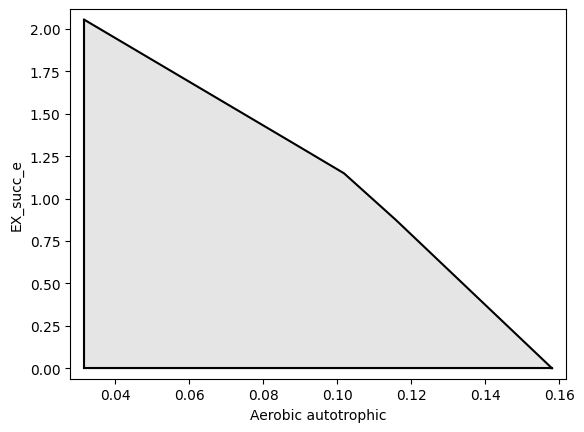

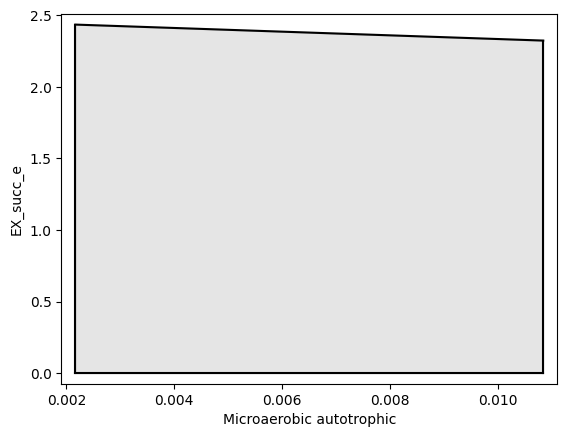

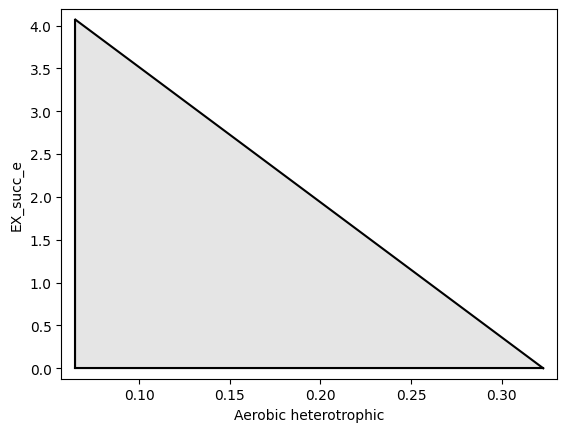

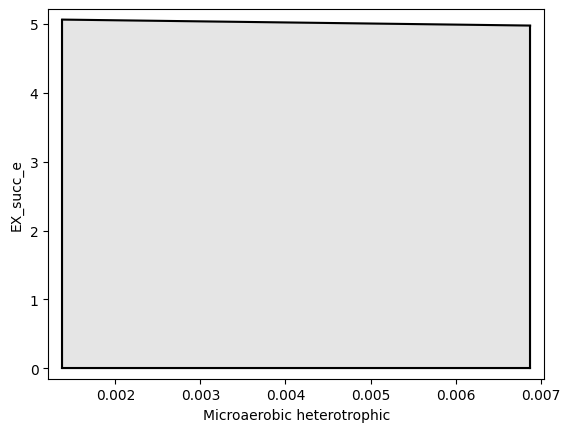

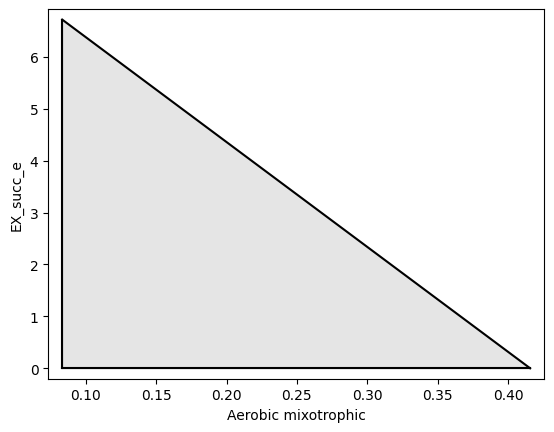

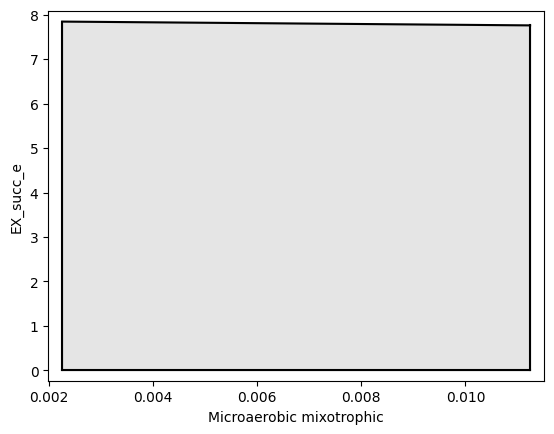

In [20]:
"""
for every graph y axis represent the succiante production and the x axis represent the the gorwth rate for each
environmental condition
"""
production_env_mewpy(growth_env,model_1_d,growth_a)

<div align='justify'>
As seen in the production envelope graphics, for the aerobic conditions, the organism shows less production of succinate and the producion of this product decreases considerably with the increase of biomass production rate, however for the microaerobic conditions the production of succinate is higer and there's a small decrease in the production with the increase of biomass production rate
</div>

## f) Try to improve the production of the compound by changing the update rates and/or add/remove compounds in the media.

In [21]:
model_1_f=cobra.io.read_sbml_model("iRC1080_lv3.xml")

In [22]:
#functions to solve exercise 1f)

def restricoes_f(cond_growth:str,model_1_f):
    """
    This function recieves the enviromental condition and makes the respective medium modifications
    """
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']
    condition={
        "Aerobic autotrophic"        : [-2000,-11.16,-10,0,0],
        "Microaerobic autotrophic"   : [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic"      : [0,-11.16,-10,-10,-1.72e-4],
        "Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic"        : [-2000,-11.16,-10,-10,-1.72e-4],
        "Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]
    }

    for reaction_id,uptake in zip(exchage_interest,condition[cond_growth]):
        
        if model_1_f.reactions.get_by_id(reaction_id).lower_bound!=uptake:
            model_1_f.reactions.get_by_id(reaction_id).lower_bound=uptake

def restricoes_1_f(cond_growth,conditions,model_1_f):
    """
    This function recieves the enviromental condition and makes the respective medium modifications
    """
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']
 

    for reaction_id,uptake in zip(exchage_interest,conditions[cond_growth]):
        
        if model_1_f.reactions.get_by_id(reaction_id).lower_bound!=uptake:
            model_1_f.reactions.get_by_id(reaction_id).lower_bound=uptake

def restricao_f(id_reac:str,flux:float,model_1_f):
    model_1_f.reactions.get_by_id(id_reac).lower_bound=flux
    
def rmv_prism_f(cond_growth:str,model_1_f):
    '''
    This function removes the PRISM reactions when light is absence in the medium
    '''
    prism=model_1_f.reactions.query("PRISM")
    lower_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    upper_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    
    if "heterotrophic" in cond_growth:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_1_f.reactions.get_by_id(reaction_id).lower_bound=0
            model_1_f.reactions.get_by_id(reaction_id).upper_bound=0

    else:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_1_f.reactions.get_by_id(reaction_id).upper_bound= upper_default[I]
            model_1_f.reactions.get_by_id(reaction_id).lower_bound= lower_default[I]

def opt_objetctive_f(cond_growth:str,model_1_f):
    "This funcion modifies the optimization objetive depending on the enviromental conditions wanted"

    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}
    
    objective_reaction=model_1_f.reactions.get_by_id(env_cond[cond_growth])
    model_1_f.objective=objective_reaction
    return model_1_f.objective

def optimization_f(cond_growth:str,model_1_f):
    '''
    This function makes the model optimizations depending on the enviromental condition given
    '''
    restricoes_f(cond_growth,model_1_f)
    rmv_prism_f(cond_growth,model_1_f)
    opt_objetctive_f(cond_growth,model_1_f)
    #solution=model_1_f.optimize()
    #return solution

def produced_metabolites_f(conds_growth:list[str],model_1_f)->dict[str,dict[str,float]]:
    '''
    This function recieves all the enviromental conditions in study and gives back the metabolites produced by the organism
    for each condition
    '''
    prod_metabolites={}
    for cond in conds_growth:
        prod_metabolites[cond]={}
        for metabolite,flux in zip(model_1_f.summary().secretion_flux.metabolite,model_1_f.summary().secretion_flux.flux):
            if flux!=0:
                prod_metabolites[cond][metabolite]=flux
    
    return prod_metabolites

def consumed_metabolites_1_f(conds_growth:list[str],model_1_f)->dict[str,dict[str,float]]:
    '''
    This function recieves all the enviromental conditions in study and gives back the metabolites used by the organism
    for each condition
    '''
    metabolites={}
    for cond in conds_growth:
        metabolites[cond]={}
        for metabolite,flux in zip(model_1_f.summary().uptake_flux.metabolite,model_1_f.summary().uptake_flux.flux):
            if flux!=0:
                metabolites[cond][metabolite]=flux
    
    return metabolites

def BCPY_group1_f(product:dict[str,dict[str,float]],growth_rate:float,substrate:dict[str,dict[str,float]])->float:
    """
    This function calculates the BCPY value for the porduction of certain product
    """
    res=0
    for env_cond in product:
        product_flux=product[env_cond]["succ_e"]*carbon_number('succ_e')
        growth=growth_rate
        carbon_flux=0
        for carbon,flux in substrate[env_cond].items():
            carbon_flux+=flux*carbon_number(carbon)
        res=-(product_flux*growth_rate)/(carbon_flux)
    return res

def one_val_modif(val,model_1_f):    
    conditions_f={"Aerobic autotrophic": [-2000,-11.16,-10,0,0],"Microaerobic autotrophic": [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic": [0,-11.16,-10,-10,-1.72e-4],"Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic": [-2000,-11.16,-10,-10,-1.72e-4],"Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]}
    
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']

    for cond in conditions_f:  
        for reac_id,flux in zip(exchage_interest,conditions_f[cond]):
            optimization_f(cond,model_1_f)
            model_1_f.optimize()
            if reac_id!='EX_photonVis_e':
                flux_=flux*val
                restricao_f(reac_id,flux_,model_1_f)
                solution=model_1_f.optimize()
                secreted_metabolites_f=produced_metabolites_f([cond],model_1_f) 
                succ=compound_int([cond],secreted_metabolites_f,"succ_e")
                carbons=carbon_source(succ,consumed_metabolites_1_f([cond],model_1_f))
                
                print(f"{cond}: {reac_id}:{flux}*{val}")
                print("Growth rate:",solution.objective_value)
                print("succ_e:","{:0.2e}".format(BCPY_group1_f(succ,solution.objective_value,carbons)),"mmol/gDW/h",end="\n\n")

def all_val(val,model_1_f):    
    conditions_f={"Aerobic autotrophic": [-2000,-11.16,-10,0,0],"Microaerobic autotrophic": [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic": [0,-11.16,-10,-10,-1.72e-4],"Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic": [-2000,-11.16,-10,-10,-1.72e-4],"Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]}
    
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']

    for cond in conditions_f:  
        fluxes=[]
        res={}
        for reac_id,flux in zip(exchage_interest,conditions_f[cond]):
            if reac_id!='EX_photonVis_e':
                fluxes=fluxes+[flux*val]
            else:
                pass
        res[cond]=fluxes
        restricoes_1_f(cond,res,model_1_f)
        optimization_f(cond,model_1_f)
        solution=model_1_f.optimize()
        secreted_metabolites_f=produced_metabolites_f([cond],model_1_f) 
        succ=compound_int([cond],secreted_metabolites_f,"succ_e")
        carbons=carbon_source(succ,consumed_metabolites_1_f([cond],model_1_f))   
        print(f"{cond} X {val}")
        print("Growth rate:",solution.objective_value)
        print("succ_e:","{:0.2e}".format(BCPY_group1_f(succ,solution.objective_value,carbons)),"mmol/gDW/h",end="\n\n")

In [23]:
# original values
print("Succinate production from exercise 1b):")
for con,value in production.items():
    print(f"- {con}:", "{:0.2e} mmol/gDW/h".format(value))

Succinate production from exercise 1b):
- Microaerobic mixotrophic: 2.09e-03 mmol/gDW/h


In [24]:
#single modification
one_val_modif(2,model_1_f) # doble
one_val_modif(0.5,model_1_f) #half


Aerobic autotrophic: EX_co2_e:-11.16*2
Growth rate: 0.15800954440203163
succ_e: 0.00e+00 mmol/gDW/h

Aerobic autotrophic: EX_o2_e:-10*2
Growth rate: 0.15800954440202494
succ_e: 0.00e+00 mmol/gDW/h

Aerobic autotrophic: EX_ac_e:0*2
Growth rate: 0.15800954440202494
succ_e: 0.00e+00 mmol/gDW/h

Aerobic autotrophic: SK_starch300_h:0*2
Growth rate: 0.15800954440202494
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic autotrophic: EX_co2_e:-11.16*2
Growth rate: 0.010832753607117166
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic autotrophic: EX_o2_e:-0.01*2
Growth rate: 0.021665507214234332
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic autotrophic: EX_ac_e:0*2
Growth rate: 0.010832753607117166
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic autotrophic: SK_starch300_h:0*2
Growth rate: 0.010832753607117166
succ_e: 0.00e+00 mmol/gDW/h

Aerobic heterotrophic: EX_co2_e:-11.16*2
Growth rate: 0.32300986517049246
succ_e: 0.00e+00 mmol/gDW/h

Aerobic heterotrophic: EX_o2_e:-10*2
Growth rate: 0.32300986517048225
succ_e: 0.0

<div align='justify'

As shown in 1b) the wild type production of succinate it's $2.09\times10^{-3}$ mmol/gDW/h only for the Microaerobic mixotrophic environment.
In this exercise we tried to increase the production of succinate for the wild-type by modifying the uptake of the compounds present in the medium.
We started for changing only one value at time for each condition, and we observed that still only the Microaerobic mixotrophic conditions showed the production of succinate. 


For the microaerobic mixotrophic condition, when we doubled or halve the uptake values for CO2 and acetate the production of succinate didn't change at all, but when the uptake of O2 was the double of the original value, there's an increase of the production, with the production reaching a value of $2.37\times10^{-3}$ mmol/gDW/h which results in an increase of around 13% in the succinate production. If the O2 uptake is reduced to half the production drops to $1.15\times10^{-3}$ mmol/gDW/h representing a decrease of around 45% from the original production.
If the starch uptake is doubled the production slightly changes to $2.08\times10^{-3}$ mmol/gDW/h but when the uptake is limited to half of the original value the production of succinate drops to $1.94\times10^{-3}$ mmol/gDW/h, that represents a decrease of almost 7% comparing to the original production

In [25]:
#all values modified simultaneously for each condition
all_val(2,model_1_f)

Aerobic autotrophic X 2
Growth rate: 0.15800954440202727
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic autotrophic X 2
Growth rate: 0.010832753607117157
succ_e: 0.00e+00 mmol/gDW/h

Aerobic heterotrophic X 2
Growth rate: 0.32300986517050523
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic heterotrophic X 2
Growth rate: 0.006876392022766325
succ_e: 0.00e+00 mmol/gDW/h

Aerobic mixotrophic X 2
Growth rate: 0.4157531012797876
succ_e: 0.00e+00 mmol/gDW/h

Microaerobic mixotrophic X 2
Growth rate: 0.011243906548426752
succ_e: 2.09e-03 mmol/gDW/h



When all the values are modified at the same time the production of succinate is equal to the production predicted for the exercise 1b)

# Ex2 
<div align='justify'>
 In stress conditions, microalgae  often change  their  metabolism to fight the alterations in the environment. In these scenarios, some carbon can be secreted in the form  of  organic acids. Although  some  stress  conditions  can  be  replicated directly  in GSM  models,  others, such as  temperature,  pH,  salinity,  require  the addition of additional  information,  such  as  gene expression  data. The file “expression_data.tsv” contains  the  normalized  gene  expression  profile  of  C.  reinhardii in  two  conditions: control and stress.
</div>

In [39]:
model_2=cobra.io.read_sbml_model("iRC1080_lv3.xml")
model_2.solver

In [40]:
rna_omic=pd.read_csv('expression_data.tsv',sep='\t') # loading the expression data
rna_omic

,gene_id,Control_12h,Stress_12h,Stress_12_h2
0,Cre01.g000033.v5.5,2.916050,11.346800,2.074386
1,Cre01.g000250.v5.5,13.371200,2.516420,2.433566
2,Cre01.g000300.v5.5,2.535150,5.038200,1.149793
3,Cre01.g000150.v5.5,21.137000,0.776829,4.232645
4,Cre01.g000200.v5.5,2.031320,23.919400,1.719411
...,...,...,...,...
17736,Cre52.g761647.v5.5,102.857000,13.758300,0.852842
17737,Cre50.g761497.v5.5,11.356900,89.962200,3.575397
17738,Cre51.g761547.v5.5,1.741490,11.924400,1.663222
17739,Cre51.g761597.v5.5,0.663041,2.329110,3.815924


In [41]:
#functions to solve exercise 2

def restricoes_2(cond_growth:str,model_2):
    """
    This function recieves the enviromental condition and makes the respective medium modifications
    """
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']
    condition={
        "Aerobic autotrophic"        : [-2000,-11.16,-10,0,0],
        "Microaerobic autotrophic"   : [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic"      : [0,-11.16,-10,-10,-1.72e-4],
        "Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic"        : [-2000,-11.16,-10,-10,-1.72e-4],
        "Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]
    }

    for reaction_id,uptake in zip(exchage_interest,condition[cond_growth]):
        
        if model_2.reactions.get_by_id(reaction_id).lower_bound!=uptake:
            model_2.reactions.get_by_id(reaction_id).lower_bound=uptake

def rmv_prism_2(cond_growth:str,model_2):
    '''
    This function removes the PRISM reactions when light is absence in the medium
    '''
    prism=model_2.reactions.query("PRISM")
    lower_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    upper_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    
    if "heterotrophic" in cond_growth:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_2.reactions.get_by_id(reaction_id).lower_bound=0
            model_2.reactions.get_by_id(reaction_id).upper_bound=0

    else:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_2.reactions.get_by_id(reaction_id).upper_bound= upper_default[I]
            model_2.reactions.get_by_id(reaction_id).lower_bound= lower_default[I]

def opt_objetctive_2(cond_growth:str,model_2):
    "This funcion modifies the optimization objetive depending on the enviromental conditions wanted"

    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}
    
    objective_reaction=model_2.reactions.get_by_id(env_cond[cond_growth])
    model_2.objective=objective_reaction

def optimization_2(cond_growth:str,model_2):
    '''
    This function makes the model optimizations depending on the enviromental condition given
    '''
    restricoes_2(cond_growth,model_2)
    rmv_prism_2(cond_growth,model_2)
    opt_objetctive_2(cond_growth,model_2)
    

## Control

In [ ]:
model_2=cobra.io.read_sbml_model("iRC1080_lv3.xml") #loading the model
optimization_2("Microaerobic heterotrophic", model_2) #changing the model conditions to Microaerobic heterotrophic
simul = get_simulator(model_2) 

#get genes and expression data for control from rna_omic
genes = rna_omic["gene_id"].tolist()
condition = ["Control_12h"]
expression = rna_omic[condition].to_numpy()

# load expression module for control
expr_control = ExpressionSet(genes, condition, expression)

In [ ]:
solution_control=eFlux(simul, expr_control, condition="Control_12h") #running the eFlux
as_df = solution_control.dataframe #transforming the solutins in a data frame 
as_df.loc[(as_df["Flux rate"]!=0) & (as_df.index.str.startswith("EX"))] #selecting only the exchange reactions with flux !=0

,Flux rate
Reaction ID,
EX_no3_e,-1.590716e-06
EX_etoh_e,1.455488e-06
EX_for_e,2.059075e-06
EX_h2_e,9.588582e-08
EX_h_e,2.129754e-06
EX_pi_e,2.827168e-08
EX_nh4_e,4.240752e-08
EX_o2_e,-1.988396e-07
EX_rib__D_e,1.413584e-08


In [ ]:
solution_control.fluxes["EX_succ_e"] #flux for the exchange of succinate for the control,additional information to the data frame

-0.0

<div align = "justify">
As seen in the data frame above, for the control in microaerobic heterotrophic contidion, the exchange reaction of succinate isn't shown and when we searched for it, we found that it has a flux equal to zero when we optimized the model using fba approach integrating the expression data. So we can conclude that for the control there isn't production of succinate for microaerobic heterotrophic environment and that is expected, because if we see the results of the exercise 1b) only the microaerobic mixotrophic condition showed the production of succinate, although the fva analysis showed that the results weren't robust, and we couldn't assume with 100% sure that the in microaerobic heterotrophic condition the organism couldn't produce succinate, but with these results now we can conclude that the organism doesn't produce succinate for this condition.

</div>

## Stress

In [ ]:
model_2=cobra.io.read_sbml_model("iRC1080_lv3.xml") #loading the model
optimization_2("Microaerobic heterotrophic", model_2) # changing the medium to Microaerobic heterotrophic
simul = get_simulator(model_2)

#get  genes and expression data for stress from rna_omic
genes = rna_omic["gene_id"].tolist()
condition_stress = ["Stress_12h"]
expression_stress = rna_omic[condition_stress].to_numpy()

# load expression module for stress
expr_stress = ExpressionSet(genes, condition_stress, expression_stress)

In [ ]:
solution_stress = eFlux(simul, expr_stress, condition="Stress_12h") #running the eFlux
as_df = solution_stress.dataframe #transforming the results to data frame
as_df.loc[(as_df["Flux rate"]!=0) & (as_df.index.str.startswith("EX"))] # selecting only the exchange reactions with flux !=0

,Flux rate
Reaction ID,


<div align='justify'>

When we used the fba optimization for the microaerobic heterotrophic condition while integrating the stress expression data, all the exchanges reactions turn out to have a flux equal to zero (the data frame above is empty because is constituted of every exchange reaction that has a flux different from zero), so in stress the organism also doesn't show production of succinate like in control, the difference is that in control there are exchange reaction occurring and in stress don't.

In conclusion, the results of fba with the integration of the expression data for the microaerobic heterotrophic condition make us conclude that in this condition the organism doesn't produce succinate, something that wasn't possible to say for sure on the last exercise because the fva analysis reveal that the results weren't robust. 

</div>

# Ex 3

## a) Determine the essential genes and reactions of the organism

In [4]:
model_3=cobra.io.read_sbml_model("iRC1080_lv3.xml") #loading the model

In [ ]:
essential_reactions=cobra.flux_analysis.find_essential_reactions(model_3) #finding the essencial reactions
print("This organism has {} essential reactions".format(len(essential_reactions)),end="\n\n")
for I in range(len(essential_reactions)):
    print(list(essential_reactions)[I].id)    


This organism has 340 essential reactions

CYSth
ASNS1
NADPtu
ACPT1819Z18111Z
ACOADAGAT18111Z1819Z1845Z9Z12Z15Z
LEUTA
ACOADAGAT1819Z18111Z180
LUTH
UMPth
PGD3TDS1839Z12Z15Z1613E
IMPC
GLUTRR_1
3HAD181_1
PAPA160h
HCO3_h_thi
PAPA1801819Z
ACOADAGAT18111Z1819Z1835Z9Z12Z
PPItu
GLUTRS_1
PPAtm
AGPAT1819Z1619Zh
PDS1
DGTSDS1839Z12Z15Z1819Z
UPPDC1_1
BCRPTXANH
GTPDPK_1
MGt5
DTMPK
PAPA18111Z160h
G3PAT160h
CHLDBtu
ACOADAGAT18111Z1819Z180
SERDC
DHDPRy
MCS
ASADH
ORPT
UDPGth
IGPDH
ASPK_1
AGPATCOA16018111Z
SO3t_1
PGPP18111Z160h
HSDH
DGTSDS1601845Z9Z12Z15Z
OMPDC
PAPA18111Z1819Z
ARGSS_1
BCAROH
PAPA1819Z160h
TRDR
PIt2r
SQDG1819Z160th
EX_pi_e
ASPCTm
PPHNth
DAPDC
CTPth
AGPATCOA1601819Z
DGTSDS1839Z12Z15Z18111Z
G3PAT181_1
ANTPPT
THFtm_1
MGDGS1819Z160
SQDGS160
TYRTAh
PACPT
UDPth
ACPT16018111Z
DAPE
SQDGS18111Z160
PAPA1819Z1819Z
NADPHtu
GDTP
UPP3S_1
LCYG
VALTAim
AICART
SQDGS1819Z160
AGPATCOA1801819Z
PRAMPC
HCYSth
DHAD1m
G3PAT1819Z
SULR_ferr
MGDGS1819Z1619Z
SQDGW3DS1839Z12Z15Z160
NOR
ACOADAGAT18111Z18111Z1835Z9Z12Z

In [ ]:
essential_genes=cobra.flux_analysis.find_essential_genes(model_3) #finding the essencial genes
print("This organism has {} essential genes".format(len(essential_genes)),end="\n\n")
for I in range(len(essential_genes)):
    print(list(essential_genes)[I].id)    

This organism has 137 essential genes

CRv4_Au5_s1_g1947_t1
CRv4_Au5_s11_g2516_t1
CRv4_Au5_s29_g10106_t1
CRv4_Au5_s2_g9297_t1
CRv4_Au5_s9_g15492_t1
CRv4_Au5_s3_g11232_t1
CRv4_Au5_s12_g3447_t1
CRv4_Au5_s1_g1969_t1
CRv4_Au5_s13_g4386_t1
CRv4_Au5_s5_g12185_t1
CRv4_Au5_s6_g12572_t1
CRv4_Au5_s1_g1736_t1
CRv4_Au5_s1_g1823_t1
CRv4_Au5_s17_g7362_t1
CRv4_Au5_s6_g12632_t1
CRv4_Au5_s1_g1272_t1
CRv4_Au5_s12_g3413_t1
CRv4_Au5_s12_g3139_t1
CRv4_Au5_s8_g15066_t1
CRv4_Au5_s12_g3921_t1
CRv4_Au5_s7_g13919_t1
CRv4_Au5_s12_g2885_t1
CRv4_Au5_s17_g7728_t1
CRv4_Au5_s13_g4871_t1
CRv4_Au5_s1_g2185_t1
CRv4_Au5_s1_g1834_t1
CRv4_Au5_s2_g8409_t1
CRv4_Au5_s2_g8449_t1
CRv4_Au5_s13_g4734_t1
CRv4_Au5_s6_g12863_t1
CRv4_Au5_s3_g10247_t1
CRv4_Au5_s16_g6444_t1
CRv4_Au5_s4_g11868_t1
CRv4_Au5_s2_g8877_t1
CRv4_Au5_s12_g3044_t1
CRv4_Au5_s6_g13125_t1
CRv4_Au5_s10_g320_t1
CRv4_Au5_s19_g8104_t1
CRv4_Au5_s10_g376_t1
CRv4_Au5_s8_g14760_t1
CRv4_Au5_s8_g14777_t1
CRv4_Au5_s2_g9701_t1
CRv4_Au5_s1_g1496_t1
CRv4_Au5_s3_g10772_t1
CRv4_Au

<div align='justify'>
From all the 1086 genes this organism has 137 essential genes, this means that a deletion in one of these 137 genes would result in a growth rate equal to zero or really close to zero which would make the organism unviable, resulting in its death.

From the total of 2191 reactions, 340 are essential, which means that if only one of this essential reactions get blocked the growth rate will be close to zero making the organism unviable and resulting in its death.

So when trying a gene knockout optimization we can exclude the essential genes from the optimization because we know in advance that the deletion of essentials genes will result in the death of the organism and not in an increase of succinate production.

</div>

## b) Using gene knockout optimization strategies, identify sets of solutions to improve the production of the compound. Through the optimization process account for the BCPY and WYIELD to evaluate the solutions.


In [17]:
#functions needed to solve exercise 3b)

def restricoes_3(cond_growth:str,model_3):
    """
    This function recieves the enviromental condition and makes the respective medium modifications
    """
    exchage_interest=['EX_photonVis_e','EX_co2_e','EX_o2_e','EX_ac_e','SK_starch300_h']
    condition={
        "Aerobic autotrophic"        : [-2000,-11.16,-10,0,0],
        "Microaerobic autotrophic"   : [-2000,-11.16,-0.01,0,0],
        "Aerobic heterotrophic"      : [0,-11.16,-10,-10,-1.72e-4],
        "Microaerobic heterotrophic" : [0,-11.16,-0.01,-10,-1.72e-4],
        "Aerobic mixotrophic"        : [-2000,-11.16,-10,-10,-1.72e-4],
        "Microaerobic mixotrophic"   : [-2000,-11.16,-0.01,-10,-1.72e-4]
    }

    for reaction_id,uptake in zip(exchage_interest,condition[cond_growth]):
        if model_3.reactions.get_by_id(reaction_id).lower_bound!=uptake:
            model_3.reactions.get_by_id(reaction_id).lower_bound=uptake

def rmv_prism_3(cond_growth:str,model_3):
    '''
    This function removes the PRISM reactions when light is absence in the medium
    '''
    prism=model_3.reactions.query("PRISM")
    lower_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    upper_default=[646.06656, 417.5912, 15.94176, 8.09577, 44.63332, 17.5256, 36.15037, 58.46722, 4.59151, 96.62811, 3.653, 51.8841087821545]
    
    if "heterotrophic" in cond_growth:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_3.reactions.get_by_id(reaction_id).lower_bound=0
            model_3.reactions.get_by_id(reaction_id).upper_bound=0

    else:
        for I in range(len(prism)):
            reaction_id=prism[I].id
            model_3.reactions.get_by_id(reaction_id).upper_bound= upper_default[I]
            model_3.reactions.get_by_id(reaction_id).lower_bound= lower_default[I]

def opt_objetctive_3(cond_growth:str,model_3):
    "This funcion modifies the optimization objetive depending on the enviromental conditions wanted"

    env_cond={"Aerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Microaerobic autotrophic":"BIOMASS_Chlamy_auto",
        "Aerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Microaerobic heterotrophic":"BIOMASS_Chlamy_hetero",
        "Aerobic mixotrophic":"BIOMASS_Chlamy_mixo",
        "Microaerobic mixotrophic":"BIOMASS_Chlamy_mixo"}
    
    objective_reaction=model_3.reactions.get_by_id(env_cond[cond_growth])
    model_3.objective=objective_reaction
    return model_3.objective

def optimization_3(cond_growth:str,model_3):
    '''
    This function makes the model optimizations depending on the enviromental condition given
    '''
    restricoes_3(cond_growth,model_3)
    rmv_prism_3(cond_growth,model_3)
    opt_objetctive_3(cond_growth,model_3)

def knock_out_succ_prod(final_pop_GKOP,problem_GKOP):
    '''
    This function recieves the GKOP problem results and the GKOP problem and finds the the modification that
    maximizes the succinate production
    '''
    max_prod=-1
    sol=0
    for indice in range(len(final_pop_GKOP)):
        solution=final_pop_GKOP[indice]
        solution.constraints
        sim = problem_GKOP.simulator
        res=sim.simulate(constraints=solution.constraints,method='ROOM')
        sol_GKOP_int=res.find([PRODUCT_ID,BIOMASS_ID,'EX_co2_e','EX_ac_e','SK_starch300_h']) #searching for the fluxes of interest
        reactions_interest=[PRODUCT_ID,BIOMASS_ID,'EX_co2_e','SK_starch300_h','EX_ac_e',]
        reaction_flux_GKOP={}
        for I in range(len(reactions_interest)):    
            reaction_flux_GKOP[reactions_interest[I]]=sol_GKOP_int["Flux rate"][I]
        carbon_sources_fluxes=(-reaction_flux_GKOP['EX_co2_e']*1+-reaction_flux_GKOP['EX_ac_e']*2+-reaction_flux_GKOP['SK_starch300_h']*6*300)
        succ_prod_GKOP=reaction_flux_GKOP['EX_succ_e']*4*reaction_flux_GKOP['BIOMASS_Chlamy_mixo']/carbon_sources_fluxes
        if succ_prod_GKOP>max:
            max=succ_prod_GKOP
            sol=indice
            constrains=solution.constraints
    
    print('Maximum succinate production with genes knock out modification number {}'.format(sol))
    print('{:0.2e}'.format(max_prod),'mmol/gDW/h')
    print('Constrains applied to the model: {}'.format(constrains))

In [13]:
optimization("Microaerobic mixotrophic",model_3) #changing the conditions to microaerobic mixotrophic
sim=get_simulator(model_3) #loading model in mewpy

BIOMASS_ID = "BIOMASS_Chlamy_mixo" # reaction id for biomass production
PRODUCT_ID="EX_succ_e" # reaction id for the production of succinate

# Optimization objectives
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method='lMOMA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

In [ ]:
# build of a new problem instance for gene knockout
problem_GKOP = GKOProblem(model_3, fevaluation=[evaluator_1, evaluator_2], candidate_max_size=5,non_target=(list(essential_genes)))

# build of a new problem instance for over and under gene expression
problem_GOUP = GOUProblem(model_3, fevaluation=[evaluator_1, evaluator_2],candidate_max_size=3)

In [ ]:
#resolving the GKOP problem
ea_GKOP = EA(problem_GKOP, max_generations= 30, visualizer=False)
final_pop_GKOP = ea_GKOP.run()

#storing the results
GKOP_df = ea_GKOP.dataframe()
GKOP_df.to_csv("GKOP_df.csv", index=False)

In [ ]:
#resolving the GOUP problem
ea_GOUP = EA(problem_GOUP, max_generations= 10, visualizer=False)
final_pop_GOUP=ea_GOUP.run()

#storing the results
GOUP_df = ea_GOUP.dataframe()
GOUP_df.to_csv("GOUP_df.csv", index=False)

### Results analysis of the gene knock out problem 

In [21]:
GKOP=pd.read_csv('GKOP_df.csv') #loading the GOUP problem results
GKOP

,Modification,Size,BPCY,WYIELD
0,"{'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s2_g958...",4,0.000744,2.329606
1,"{'CRv4_Au5_s2_g8272_t1': 0, 'CRv4_Au5_s12_g375...",5,0.000708,2.331078
2,"{'CRv4_Au5_s10_g896_t1': 0, 'CRv4_Au5_s2_g8272...",5,0.000650,2.331771
3,"{'CRv4_Au5_s2_g8272_t1': 0, 'CRv4_Au5_s12_g375...",5,0.000548,2.335153
4,"{'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s7_g142...",5,0.000592,2.334044
5,"{'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s2_g958...",5,0.000750,2.329606
6,"{'CRv4_Au5_s1_g1958_t1': 0, 'CRv4_Au5_s2_g8272...",5,0.000679,2.331148
7,"{'CRv4_Au5_s1_g1958_t1': 0, 'CRv4_Au5_s12_g375...",5,0.000744,2.329746
8,"{'CRv4_Au5_s1_g1958_t1': 0, 'CRv4_Au5_s12_g375...",5,0.000570,2.334184
9,"{'CRv4_Au5_s10_g896_t1': 0, 'CRv4_Au5_s2_g8272...",5,0.000496,2.335640


Max BPCY:
5    {'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s2_g958...
Name: Modification, dtype: object
["{'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s2_g9589_t1': 0, 'CRv4_Au5_s9_g15693_t1': 0, 'CRv4_Au5_s20_g8200_t1': 0, 'CRv4_Au5_s26_g9990_t1': 0}"]

Max WYIELD:
9    {'CRv4_Au5_s10_g896_t1': 0, 'CRv4_Au5_s2_g8272...
Name: Modification, dtype: object
["{'CRv4_Au5_s10_g896_t1': 0, 'CRv4_Au5_s2_g8272_t1': 0, 'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s7_g14228_t1': 0, 'CRv4_Au5_s2_g9589_t1': 0}"]



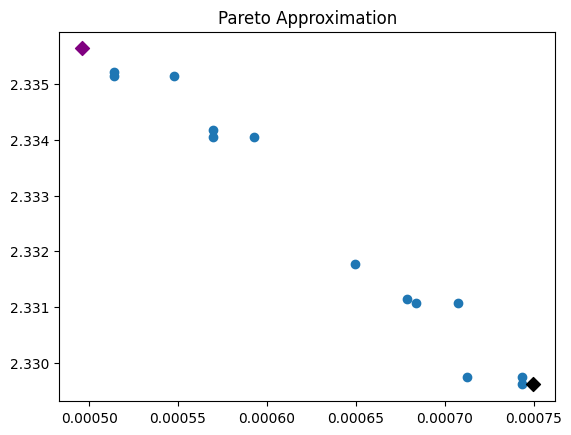

In [27]:
#Graphic vizualisation of GKOP the results
plt.title('Pareto Approximation')
plt.scatter(GKOP.BPCY, GKOP.WYIELD)

# Identify gene knockout combination which maximizes BPCY
filt = GKOP.BPCY == max(GKOP.BPCY)
max_BCPY_GKO = (GKOP.Modification[filt])
print('Max BPCY:')
print(max_BCPY_GKO)
print(list(max_BCPY_GKO),end='\n\n')

# max BCPY point
plt.scatter(GKOP.BPCY[filt], GKOP.WYIELD[filt], color='black', s=50, marker='D', label='Max BPCY')

# Identify gene knockout combination which maximizes WYIELD
filt = GKOP.WYIELD == max(GKOP.WYIELD) 
max_WYIELD_GKO = (GKOP.Modification[filt])
print('Max WYIELD:')
print(max_WYIELD_GKO)
print(list(max_WYIELD_GKO),end='\n\n')

# max WYIELD point
plt.scatter(GKOP.BPCY[filt], GKOP.WYIELD[filt], color='purple', s=50, marker='D', label='Max WYIELD')


<div align='justify'>
The graphic above shows the results obtained in the gene knockout optimization problem. The purple point represents the modification which gives the maximum value to the evaluator WYIELD and the black one gives the maximum value to the evaluator BPCY. We used a function to analyze all the modifications that resulted of the solution of the gene knock and gives out the best modification which maximizes the succinate production

In [ ]:
knock_out_succ_prod(final_pop_GKOP,problem_GKOP) # choosing the modification which maximizes the succinate production

/tmp/ipykernel_2853222/1693027399.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reaction_flux_GKOP[reactions_interest[I]]=sol_GKOP_int["Flux rate"][I]
/tmp/ipykernel_2853222/1693027399.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reaction_flux_GKOP[reactions_interest[I]]=sol_GKOP_int["Flux rate"][I]
/tmp/ipykernel_2853222/1693027399.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reaction_flux_GKOP[reactions_inte

Maximum succinate production with genes knock out modification number 5
2.64e-03 mmol/gDW/h
Constrains applied to the model: {'HBCO_nadp': 0, 'ATDGDm': 0, 'HBCO_nadp_m': 0, 'ATGDm': 0, 'NDPK4m': 0, 'NDPK8m': 0, 'NDPK3m': 0, 'NDPK2m': 0, 'NDPK7m': 0, 'NITR': 0, 'NDPK9m': 0, 'CCP2m': 0, 'ORNtm': 0, 'NDPK6m': 0}


/tmp/ipykernel_2853222/1693027399.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reaction_flux_GKOP[reactions_interest[I]]=sol_GKOP_int["Flux rate"][I]


In [34]:
# selecing the genes knocked out in modification 5
for I,mod in enumerate(GKOP.Modification):
    if I== 5:
        modification_GKOP=mod
        print('Knocked out genes:',modification_GKOP)
        print('Number of knocked out genes: 5',end='\n\n')

# analysing the reactions knocked out and the genes involved
reactions_KO=['HBCO_nadp','ATDGDm','HBCO_nadp_m','ATGDm','NDPK4m','NDPK8m','NDPK3m','NDPK2m','NDPK7m','NITR','NDPK9m','CCP2m','ORNtm','NDPK6m'] # obtained in the knock_out_succ_prod function
print('Number of knocked out reaction:',len(reactions_KO))
for reac in reactions_KO:
    print('Reaction (name, reaction):',model.reactions.get_by_id(reac))
    print('\tGenes involved in the reaction:',model.reactions.get_by_id(reac).gpr,end='\n\n')  

Knocked out genes: {'CRv4_Au5_s12_g3750_t1': 0, 'CRv4_Au5_s2_g9589_t1': 0, 'CRv4_Au5_s9_g15693_t1': 0, 'CRv4_Au5_s20_g8200_t1': 0, 'CRv4_Au5_s26_g9990_t1': 0}
Number of knocked out genes: 5

Number of knocked out reaction: 14
Reaction (name, reaction): HBCO_nadp: aacoa_c + h_c + nadph_c <=> 3hbcoa_c + nadp_c
	Genes involved in the reaction: CRv4_Au5_s12_g3750_t1

Reaction (name, reaction): ATDGDm: atp_m + dgdp_m + h_m --> adp_m + dgtp_m
	Genes involved in the reaction: CRv4_Au5_s26_g9990_t1

Reaction (name, reaction): HBCO_nadp_m: aacoa_m + h_m + nadph_m <=> 3hbcoa_m + nadp_m
	Genes involved in the reaction: CRv4_Au5_s12_g3750_t1

Reaction (name, reaction): ATGDm: atp_m + gdp_m + h_m --> adp_m + gtp_m
	Genes involved in the reaction: CRv4_Au5_s26_g9990_t1

Reaction (name, reaction): NDPK4m: atp_m + dtdp_m --> adp_m + dttp_m
	Genes involved in the reaction: CRv4_Au5_s26_g9990_t1

Reaction (name, reaction): NDPK8m: atp_m + dadp_m --> adp_m + datp_m
	Genes involved in the reaction: CRv4_A

<div align='justify'>

From the results of gene knock out problem, the solution that gives the maximum increase of succinate production is the modification 5 (the number of modifications will start from 0). This modification implies the knock out of 5 genes (CRv4_Au5_s12_g3750_t1, CRv4_Au5_s2_g9589_t1, CRv4_Au5_s9_g15693_t1, CRv4_Au5_s20_g8200_t1 and CRv4_Au5_s26_g9990_t1) which ended up resulting in the knock out of 14 reactions (HBCO_nadp, ATDGDm, HBCO_nadp_m, ATGDm, NDPK4m, NDPK8m, NDPK3m, NDPK2m, NDPK7m, NITR, NDPK9m, CCP2m, ORNtm and NDPK6m'). With this modification the succinate production increases from $2.09\times10^{-3}$ mmol/gDW/h in the wild-type to $2.64\times10^{-3}$ mmol/gDW/h in the mutants representing an increase of around 26%.


### Results analysis of the gene under/over expression problem 

In [29]:
#loading the results of GOUP problem
GOUP=pd.read_csv('GOUP_df.csv')
GOUP

,Modification,Size,BPCY,WYIELD
0,{'CRv4_Au5_s6_g12484_t1': 8},1,0.003439,2.542654
1,"{'CRv4_Au5_s6_g12484_t1': 8, 'CRv4_Au5_s12_g39...",2,0.001759,2.556750
2,"{'CRv4_Au5_s12_g2763_t1': 0.125, 'CRv4_Au5_s3_...",2,0.000017,2.356263
3,"{'CRv4_Au5_s12_g3984_t1': 4, 'CRv4_Au5_s1_g203...",3,0.000076,2.346371
4,"{'CRv4_Au5_s13_g4386_t1': 4, 'CRv4_Au5_s8_g148...",2,0.000413,2.331810
5,"{'CRv4_Au5_s7_g13718_t1': 8, 'CRv4_Au5_s12_g39...",2,0.000181,2.343966
6,"{'CRv4_Au5_s12_g3921_t1': 32, 'CRv4_Au5_s6_g13...",2,0.000214,2.343933
7,"{'CRv4_Au5_s13_g4386_t1': 4, 'CRv4_Au5_s12_g28...",2,0.000360,2.334498
8,"{'CRv4_Au5_s12_g2763_t1': 0.125, 'CRv4_Au5_s12...",3,0.000024,2.356263
9,"{'CRv4_Au5_s7_g13718_t1': 4, 'CRv4_Au5_s12_g39...",3,0.000201,2.343948


Max BPCY:
0    {'CRv4_Au5_s6_g12484_t1': 8}
Name: Modification, dtype: object
["{'CRv4_Au5_s6_g12484_t1': 8}"]

Max WYIELD:
1    {'CRv4_Au5_s6_g12484_t1': 8, 'CRv4_Au5_s12_g39...
Name: Modification, dtype: object
["{'CRv4_Au5_s6_g12484_t1': 8, 'CRv4_Au5_s12_g3921_t1': 32}"]

Max score modification:
1    {'CRv4_Au5_s6_g12484_t1': 8, 'CRv4_Au5_s12_g39...
Name: Modification, dtype: object
["{'CRv4_Au5_s6_g12484_t1': 8, 'CRv4_Au5_s12_g3921_t1': 32}"]



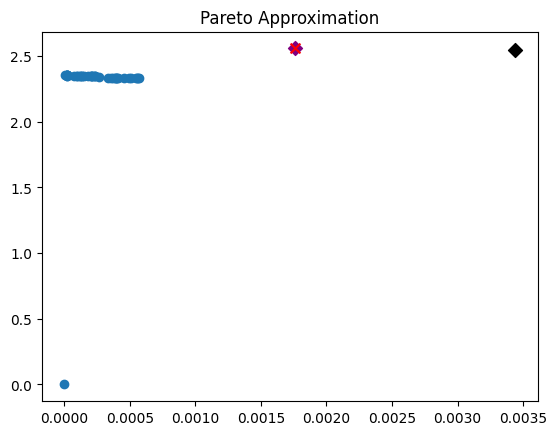

In [30]:
#Graphic vizualisation of the results
plt.title('Pareto Approximation')
plt.scatter(GOUP.BPCY, GOUP.WYIELD)

# Identify gene knockout combination which maximizes BPCY
filt = GOUP.BPCY == max(GOUP.BPCY)
max_BCPY_GKO = (GOUP.Modification[filt])
print('Max BPCY:')
print(max_BCPY_GKO)
print(list(max_BCPY_GKO),end='\n\n')

# max BCPY point
plt.scatter(GOUP.BPCY[filt], GOUP.WYIELD[filt], color='black', s=50, marker='D', label='Max BPCY')

# Identify gene knockout combination which maximizes WYIELD
filt = GOUP.WYIELD == max(GOUP.WYIELD) 
max_WYIELD_GKO = (GOUP.Modification[filt])
print('Max WYIELD:')
print(max_WYIELD_GKO)
print(list(max_WYIELD_GKO),end='\n\n')

# max WYIELD point
plt.scatter(GOUP.BPCY[filt], GOUP.WYIELD[filt], color='purple', s=50, marker='D', label='Max WYIELD')

#Identify gene knock out combination which maximizes alpha*BPCY + (1 - alpha)*WYIELD
alpha=0.5 #giving the same weight fot both evaluaters
score = alpha*GOUP.BPCY + (1 - alpha)*GOUP.WYIELD
filt = score == max(score) 
modification= GOUP.Modification[filt]
print('Max score modification:')
print(modification)
print(list(modification),end='\n\n')

# max score point
plt.scatter(GOUP.BPCY[filt], GOUP.WYIELD[filt], color='red', s=50, marker='x', label='Max alpha score')

<div align='justify'>
The graphic above shows the results obtained in the gene under/over expression optimization problem. The purple point represents the modification which gives the maximum value to the evaluator WYIELD and the black one gives the maximum value to the evaluator BPCY. The point with a red cross in the graph matches the best modification considering that both of the evaluators have the same weight when calculating the score. The max score modification matches the max WYIELD point which is the modification number 1 (the modifications are numerated starting with 0).

In [ ]:
solution = final_pop_GOUP[1] # choosing the modification number 1 from the GOUP results
solution

[0.0017589343404367259, 2.556750491405504];{'CRv4_Au5_s6_g12484_t1': 8, 'CRv4_Au5_s12_g3921_t1': 32}

In [ ]:
solution.constraints # seeing the constrains that the modification 1 will add to the model to represent the overexpression of the 2 genes

{'ACDO': (0.004934202834999497, 10000), 'FUMm': (-10000, -0.3020999956475551)}

In [ ]:
sim = problem_GOUP.simulator #loading the problem
res=sim.simulate(constraints=solution.constraints,method='ROOM') # running the simulation using ROOM
res

objective: 0.0
Status: OPTIMAL
Method:ROOM

In [ ]:
sol_GOUP_int=res.find([PRODUCT_ID,BIOMASS_ID,'EX_co2_e','EX_ac_e','SK_starch300_h']) #searching for the fluxes of interest
print(sol_GOUP_int)

                     Flux rate
Reaction ID                   
EX_succ_e             0.303710
BIOMASS_Chlamy_mixo   0.004791
EX_co2_e             -1.065200
SK_starch300_h       -0.000170
EX_ac_e              -0.016492


Note: In the data frame above the positives values mean secretion and the negatives values mean uptake 

In [ ]:
#changing the data structure from data frame to a dictionary
reactions_interest=[PRODUCT_ID,BIOMASS_ID,'EX_co2_e','SK_starch300_h','EX_ac_e',]
reaction_flux_GOUP={}
for I in range(len(reactions_interest)):    
    reaction_flux_GOUP[reactions_interest[I]]=sol_GOUP_int["Flux rate"][I]

In [ ]:
#calculating of the succinate production with the modification 1 applied
carbon_sources_fluxes=(-reaction_flux_GOUP['EX_co2_e']*1+-reaction_flux_GOUP['EX_ac_e']*2+-reaction_flux_GOUP['SK_starch300_h']*6*300)
succ_prod_GKOP=reaction_flux_GOUP['EX_succ_e']*4*reaction_flux_GOUP['BIOMASS_Chlamy_mixo']/carbon_sources_fluxes
print('Succinate production with gene')
print('{:0.2e}'.format(succ_prod_GKOP),'mmol/gDW/h')

Succinate production with gene
4.15e-03 mmol/gDW/h


<div align='justify'>
As seen above, when the modification with the best score is chosen the model gets new constrains that represent the over expression of the genes CRv4_Au5_s6_g12484_t1 and CRv4_Au5_s12_g3921_t1, which results in the modification of the bounds in the reactions that these genes are required. The reactions are ACDO (0.004934202834999497, 10000) and FUMm (-10000, -0.3020999956475551). 

The over expression increases the production of succinate considerably, the wild-type has a production of $2.09\times10^{-3}$ mmol/gDW/h while when these genes are over expressed the production of succinate almost double being $4.15\times10^{-3}$ mmol/gDW/h.

# Conclusion

<div align='justify'>
Considering all the results, the best theoretical way to improve the succinate production is using Microaerobic mixotrophic medium, promoting the over expression of the genes CRv4_Au5_s6_g12484_t1 and CRv4_Au5_s12_g3921_t1, knocking out the genes CRv4_Au5_s12_g3750_t1, CRv4_Au5_s2_g9589_t1,CRv4_Au5_s9_g15693_t1, CRv4_Au5_s20_g8200_t1, CRv4_Au5_s26_g9990_t1 and increase the O2 concentration in the medium to the double of the one used in Microaerobic mixotrophic conditions. This way is possible to double the succinate production in Chlamydomonas reinhardtii.
However, this is the best theoretical way to improve the succinate production, this doesn't mean that this approach will work when doing experiments, because as we demonstrated above there is a large set of genes to knock out which technically can be hard to implement or, when all the changes are applied, there's a change of the organism adapt differently compared to what was predicted, so further experiments are necessary to access if this strategy results in the increase of succinate production.